In [140]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases
from dnn_utils import sigmoid,sigmoid_backward,relu,relu_backward
import lr_utils

In [141]:
np.random.seed(1)

In [142]:
def init_params(layers_dims):
    
    np.random.seed(1)
    params = {}
    
    for l in range(1,len(layers_dims)):
        params["W" + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        params["b" + str(l)] = np.zeros((layers_dims[l],1))
        
    return params

In [143]:
def linear_forward(A,W,b):
    """前向传播线性部分"""
    Z = W @ A + b
    cache = (A,W,b)
    
    return Z,cache

In [144]:
# 线性部分测试
A,W,b = testCases.linear_forward_test_case()
Z,linear_cache = linear_forward(A,W,b)
Z

array([[ 3.26295337, -1.23429987]])

In [145]:
def activation_forward(A_pre,W,b,activation):
    """前向传播激活部分"""
    if activation == "sigmoid":
        Z,linear_cache = linear_forward(A_pre,W,b)
        A,activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z,linear_cache = linear_forward(A_pre,W,b)
        A,activation_cache = relu(Z)
        
    cache = (linear_cache,activation_cache)
    
    return A,cache

In [146]:
# 激活部分测试
A_pre,W,b = testCases.linear_activation_forward_test_case()
A,linear_activation_cache = activation_forward(A_pre,W,b,activation="sigmoid")
print(A)
A,linear_activation_cache = activation_forward(A_pre,W,b,activation="relu")
print(A)

[[0.96890023 0.11013289]]
[[3.43896131 0.        ]]


In [147]:
def model_forward(X,params):
    """多层模型前向传播"""
    caches = []
    A = X 
    L = len(params) // 2
    
    for l in range(1,L):
        A_pre = A
        A,cache = activation_forward(A_pre,params['W'+str(l)],params['b'+str(l)],"relu")
        caches.append(cache)
        
    AL,cache = activation_forward(A,params['W'+str(L)],params['b'+str(L)],"sigmoid")
    caches.append(cache)
    
    return AL,caches

In [148]:
# 测试前向传播
X,params = testCases.L_model_forward_test_case()
AL,caches = model_forward(X,params)
AL,len(caches)

(array([[0.17007265, 0.2524272 ]]), 2)

In [149]:
def costFunction(AL,Y):
    """计算损失函数"""
    m = Y.shape[1]
    
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL),1 - Y)) / m
    cost = np.squeeze(cost)
    
    return cost

In [150]:
# 测试损失函数
Y,AL = testCases.compute_cost_test_case()
costFunction(AL,Y)

0.414931599615397

In [151]:
def linear_backward(dZ,cache):
    """反向传播线性部分"""
    A_pre,W,b = cache
    m = A_pre.shape[1]
    
    dW = dZ @ A_pre.T / m 
    db = np.sum(dZ,axis=1,keepdims=True) / m 
    dA_pre = W.T @ dZ
    
    return dA_pre,dW,db

In [152]:
# 线性部分测试
dZ,linear_cache = testCases.linear_backward_test_case()
dA_pre,dW,db = linear_backward(dZ,linear_cache)
print(dA_pre,dW,db)

[[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]] [[-0.10076895  1.40685096  1.64992505]] [[0.50629448]]


In [153]:
def activation_backward(dA,cache,activation):
    """反向传播激活部分"""
    linear_cache,activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_pre,dW,db = linear_backward(dZ,linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_pre,dW,db = linear_backward(dZ,linear_cache)
        
    return dA_pre,dW,db

In [154]:
# 激活部分测试
AL,linear_activation_cache = testCases.linear_activation_backward_test_case()
dA_pre,dW,db =activation_backward(AL,linear_activation_cache,activation = "sigmoid")
print(dA_pre,dW,db)
dA_pre,dW,db =activation_backward(AL,linear_activation_cache,activation = "relu")
dA_pre,dW,db

[[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]] [[ 0.10266786  0.09778551 -0.01968084]] [[-0.05729622]]


(array([[ 0.44090989,  0.        ],
        [ 0.37883606,  0.        ],
        [-0.2298228 ,  0.        ]]),
 array([[ 0.44513824,  0.37371418, -0.10478989]]),
 array([[-0.20837892]]))

In [155]:
def model_backward(AL,Y,caches):
    """多层模型反向传播"""
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y,AL) - np.divide(1-Y,1-AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)],grads["dW" + str(L)],grads["db" + str(L)] = activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_pre,dW,db = activation_backward(grads["dA" + str(l+2)],current_cache,"relu")
        grads["dA" + str(l+1)] = dA_pre
        grads["dW" + str(l+1)] = dW
        grads["db" + str(l+1)] = db
        
    return grads

In [156]:
# 测试反向传播
AL,Y_assess,caches = testCases.L_model_backward_test_case()
grads = model_backward(AL,Y_assess,caches)
grads["dW1"],grads["db1"],grads["dA1"]

(array([[0.41010002, 0.07807203, 0.13798444, 0.10502167],
        [0.        , 0.        , 0.        , 0.        ],
        [0.05283652, 0.01005865, 0.01777766, 0.0135308 ]]),
 array([[-0.22007063],
        [ 0.        ],
        [-0.02835349]]),
 array([[ 0.        ,  0.52257901],
        [ 0.        , -0.3269206 ],
        [ 0.        , -0.32070404],
        [ 0.        , -0.74079187]]))

In [157]:
def update_params(params,grads,a):
    """参数更新"""
    for l in range(len(params)//2):
        params["W" + str(l+1)] = params["W" + str(l+1)] - a * grads["dW" + str(l+1)]
        params["b" + str(l+1)] = params["b" + str(l+1)] - a * grads["db" + str(l+1)]
        
    return params

In [158]:
# 参数更新测试
params,grads = testCases.update_parameters_test_case()
params = update_params(params,grads,0.1)
params["W1"],params["b1"]

(array([[-0.59562069, -0.09991781, -2.14584584,  1.82662008],
        [-1.76569676, -0.80627147,  0.51115557, -1.18258802],
        [-1.0535704 , -0.86128581,  0.68284052,  2.20374577]]),
 array([[-0.04659241],
        [-1.28888275],
        [ 0.53405496]]))

In [159]:
def two_layer_model(X,Y,layers_dims,a,iters,isPrint=False,isPlot=True):
    """两层神经网络模型"""
    np.random.seed(1)
    grads = {}
    costs = []
    
    # 初始化参数
    params = init_params(layers_dims)
    
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    # 迭代
    for i in range(iters):
        A1,cache1 = activation_forward(X,W1,b1,"relu")
        A2,cache2 = activation_forward(A1,W2,b2,"sigmoid")
        # 计算损失函数
        cost = costFunction(A2,Y)
        # 反向传播
        dA2 = - (np.divide(Y,A2) - np.divide(1-Y,1-A2))
        dA1,dW2,db2 = activation_backward(dA2,cache2,"sigmoid")
        dA0,dW1,db1 = activation_backward(dA1,cache1,"relu")
        
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        # 参数更新
        params = update_params(params,grads,a)
        W1 = params["W1"]
        b1 = params["b1"]
        W2 = params["W2"]
        b2 = params["b2"]
        
        # 打印cost
        if i % 100 == 0:
            costs.append(cost)
            if isPrint:
                print("迭代%d次，误差为%f" % (i,cost))
                
    # 绘图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.xlabel('iters')
        plt.ylabel('cost')
        plt.show()
        
    return params

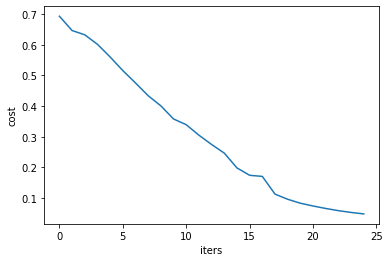

In [104]:
# 加载训练集
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes = lr_utils.load_dataset()
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
train_x = train_x_flatten/255
train_y = train_set_y
test_x = test_x_flatten/255
test_y = test_set_y
# 训练两层模型
layers_dims = [12288,7,1]
params = two_layer_model(train_x,train_y,layers_dims,a=0.0075,iters=2500)

In [160]:
def predict(X,Y,params):
    """预测"""
    m = X.shape[1]
    n = len(params) // 2
    p = np.zeros((1,m))
    
    probas, caches = model_forward(X,params)
    
    for i in range(0,probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    return p

In [106]:
# 预测训练集和测试集
train_pre = predict(train_x,train_y,params)
print("训练集：" + str(float(np.sum(train_pre == train_y)/train_x.shape[1])))
test_pre = predict(test_x,test_y,params)
print("测试集：" + str(float(np.sum(test_pre == test_y)/test_x.shape[1])))

训练集：1.0
测试集：0.72


In [161]:
def L_layer_model(X,Y,layer_dims,a,iters,isPrint=False,isPlot=True):
    """多层神经网络模型"""
    np.random.seed(2)
    costs = []
    
    params = init_params(layer_dims)
    
    for i in range(0,iters):
        AL,caches = model_forward(X,params)
        
        cost = costFunction(AL,Y)
        
        grads = model_backward(AL,Y,caches)
        
        params = update_params(params,grads,a)
        
        # 打印cost
        if i % 100 == 0:
            costs.append(cost)
            if isPrint:
                print("迭代%d次，误差为%f" % (i,cost))
                
    # 绘图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.xlabel('iters')
        plt.ylabel('cost')
        plt.show()
        
    return params

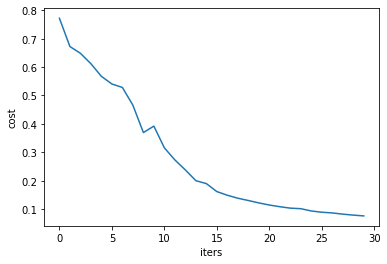

In [163]:
# 加载训练集
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes = lr_utils.load_dataset()
train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
train_x = train_x_flatten/255
train_y = train_set_y
test_x = test_x_flatten/255
test_y = test_set_y
# 训练多层模型
layers_dims = [12288,20,7,5,1]
params = L_layer_model(train_x,train_y,layers_dims,a=0.0075,iters=3000)

In [164]:
# 预测训练集和测试集
train_pre = predict(train_x,train_y,params)
print("训练集：" + str(float(np.sum(train_pre == train_y)/train_x.shape[1])))
test_pre = predict(test_x,test_y,params)
print("测试集：" + str(float(np.sum(test_pre == test_y)/test_x.shape[1])))

训练集：0.9904306220095693
测试集：0.82
